### Resumen de mensajes y externa DB

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

if os.getenv("OPENAI_API_KEY"):
    print("Cargado correctamente")

Cargado correctamente


In [4]:
import sqlite3

db_path="state_db/exmple.db"
conn=sqlite3.connect(db_path,check_same_thread = False)

In [5]:
#checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)

In [7]:
#llm
from langchain_openai import ChatOpenAI

MODEL = "gpt-4o-mini"
llm = ChatOpenAI(model=MODEL,temperature=0.6)

In [9]:
#schema
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]
    summary: str

In [17]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

#define la logica para llamar al modelo
#systemMessages
def llamar_modelo(state: State):
    summary = state.get("summary","")

    if summary:
        system_messages = f"Resume la conversación: {summary}"
        messages = [SystemMessage(content = system_messages)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": response}


In [24]:
#HummanMessages
def resumir_conversacion(state: State):
    summary = state.get("summary","")

    if summary:
        summary_message = (f"Este es el resumen hasta ahora: {summary}\n"
                        "Extiende el resumen teniendo encuenta los nuevos mensajes anteriores:")
    else: 
        summary_message = "Crea un resumen de la conversación anterior"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    #eliminar todos los mensajes excepto los dos últimos 
    delete_menssage = [RemoveMessage(id = m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages":delete_menssage}

In [ ]:
#Determina si terminar o resumir la conversación 
from langgraph.graph import END

def determinar(state: State):
    """Return el siguiente nodo a ejecutar"""
    messages = state["messages"]
    if len(messages) > 6:
        return "resumir_conversacion"
    return END

In [31]:
from langgraph.graph import StateGraph, START
#define grafo
workflow = StateGraph(State)
#define nodos
workflow.add_node("conversacion",llamar_modelo)
workflow.add_node(resumir_conversacion)
#secuencia
workflow.add_edge(START,"conversacion")
workflow.add_conditional_edges("conversacion",determinar)
workflow.add_edge("resumir_conversacion",END)
#compilar
graph = workflow.compile(checkpointer=memory)

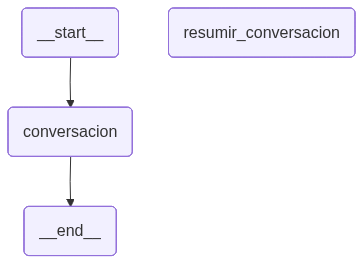

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
#crear un thread
config = {"configurable": {"thread_id":"1"}}

In [40]:
#inicia conversacion
input_msg = HumanMessage(content="hola soy Jefferson")
output_msg = graph.invoke({"messages": [input_msg]}, config)
for m in output_msg["messages"]:
    m.pretty_print()

input_msg = HumanMessage(content="Cual era mi nombre ?")
output_msg = graph.invoke({"messages": [input_msg]}, config)
for m in output_msg["messages"]:
    m.pretty_print()

input_msg = HumanMessage(content="me gusta viajar")
output_msg = graph.invoke({"messages": [input_msg]}, config)
for m in output_msg["messages"]:
    m.pretty_print()

================================ Human Message =================================

hola soy Jefferson
================================== Ai Message ==================================

¡Hola, Jefferson! ¿Cómo estás? ¿Hay algo en particular de lo que te gustaría hablar?
================================ Human Message =================================

hola soy Jefferson
================================== Ai Message ==================================

¡Hola, Jefferson! ¿Cómo estás? ¿Hay algo en particular de lo que te gustaría hablar?
================================ Human Message =================================

Cual era mi nombre ?
================================== Ai Message ==================================

Tu nombre es Jefferson. ¿Te gustaría hablar sobre algo en particular?
================================ Human Message =================================

hola soy Jefferson
================================== Ai Message ==================================

¡Hola, Jefferson! ¿Cómo es

In [37]:
#revisamos si el estado esta guardando localmente 
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='Cual era mi nombre ?', additional_kwargs={}, response_metadata={}, id='7ece0efd-edb6-40d7-a02e-45c466ef16ec'), AIMessage(content='Tu nombre es Alex. ¿Hay algo más en lo que te pueda ayudar?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 107, 'total_tokens': 123, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-COF7vs1eFxr6T7K1QjQYuVsOBWKcz', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--aeaee238-17f5-440e-a727-ea48c05c0d5a-0', usage_metadata={'input_tokens': 107, 'output_tokens': 16, 'total_tokens': 123, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': 